#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# подгружаем библиотеки
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.dummy import DummyRegressor

In [2]:
# открываем файлы
try:
    df = pd.read_csv('taxi.csv', index_col=0, parse_dates=True)
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=0, parse_dates=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# интереса ради
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# ресемплирование
df = df.resample('1H').sum().astype('uint16')

**По данным в целом ничего не скажешь. Чистые, упорядоченные. Сделали ресемплирование по часу**

## Анализ

In [5]:
# проверим на последовательность
df.index.is_monotonic

True

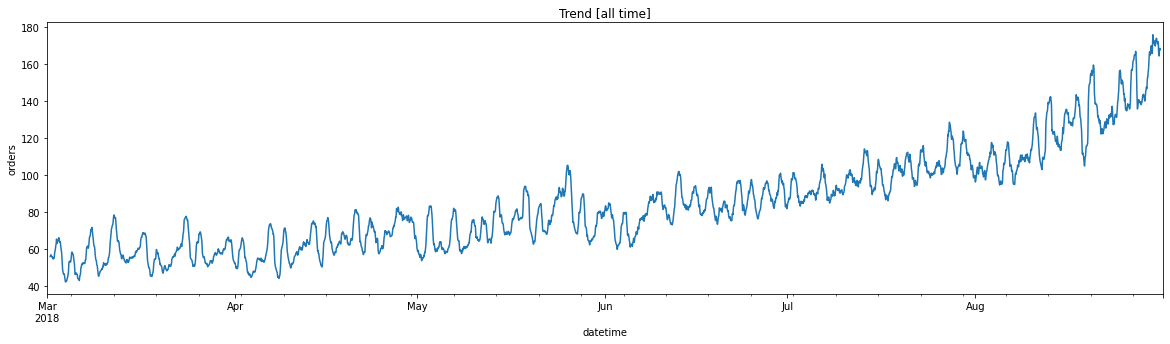

In [6]:
# посмотрим на данные в целом
decomposed_df = seasonal_decompose(df)
decomposed_df.trend.plot(figsize=(20,5), xlabel='datetime', ylabel='orders', title='Trend [all time]');

**Можно заметить рост в летний период**

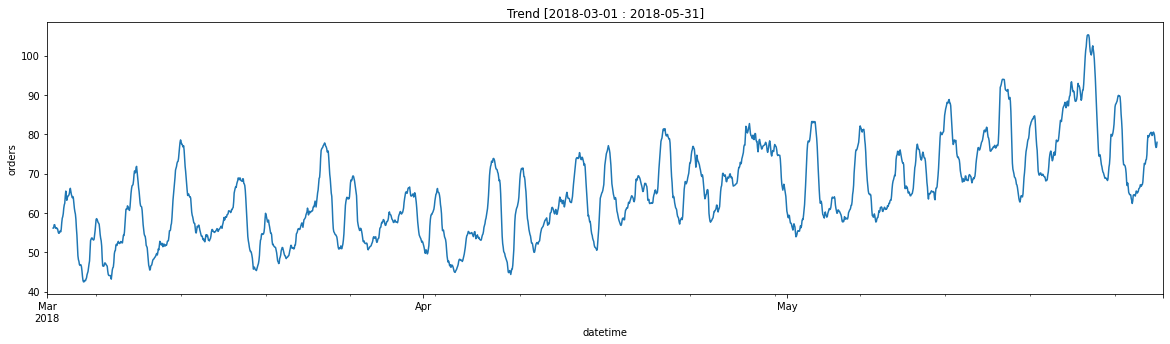

In [7]:
# рассмотрим весеннюю пору
decomposed_spring = seasonal_decompose(df['2018-03-01':'2018-05-31'])
decomposed_spring.trend.plot(figsize=(20,5), 
                             xlabel='datetime', 
                             ylabel='orders', 
                             title='Trend [2018-03-01 : 2018-05-31]');

**Здесь характерный рост наблюдается с мая**

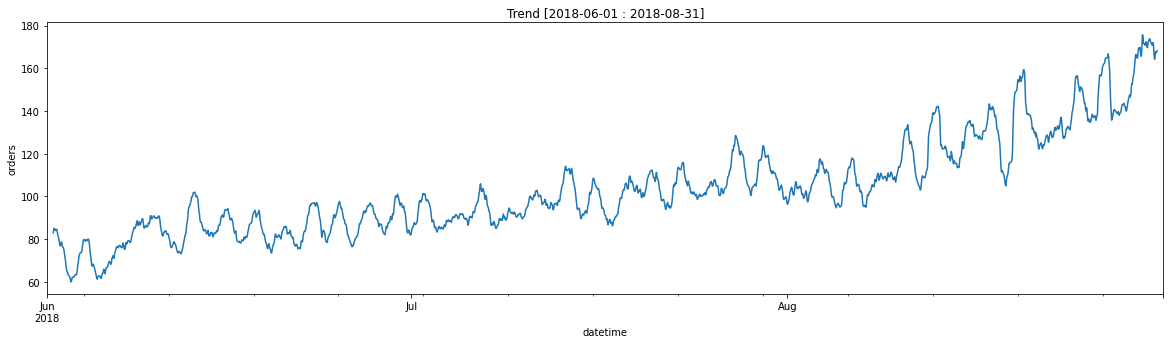

In [8]:
# рассмотрим летний период
decomposed_summer = seasonal_decompose(df['2018-06-01':'2018-08-31'])
decomposed_summer.trend.plot(figsize=(20,5), 
                             xlabel='datetime', 
                             ylabel='orders', 
                             title='Trend [2018-06-01 : 2018-08-31]');

**Тут уже рост наблюдается на всём промежутке**

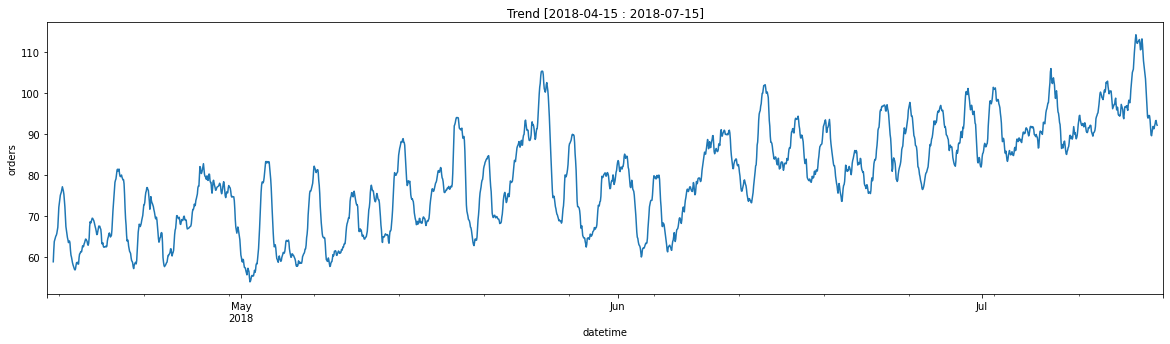

In [9]:
# Рассмотрим переход от весны к лету
decomposed_vs = seasonal_decompose(df['2018-04-15':'2018-07-15'])
decomposed_vs.trend.plot(figsize=(20,5), 
                         xlabel='datetime', 
                         ylabel='orders', 
                         title='Trend [2018-04-15 : 2018-07-15]');

**Из увиденного можно заметить, что летом идет рост использования такси. Не удивительно, начинается время отпусков и частое использование такси для поездок до аэропортов**

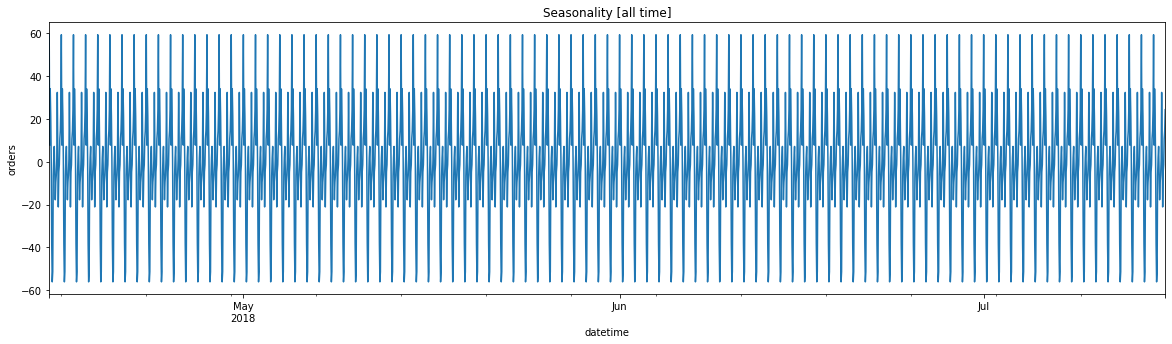

In [10]:
# рассмотрим сезонность
decomposed_vs.seasonal.plot(figsize=(20,5), 
                            xlabel='datetime', 
                            ylabel='orders', 
                            title='Seasonality [all time]');

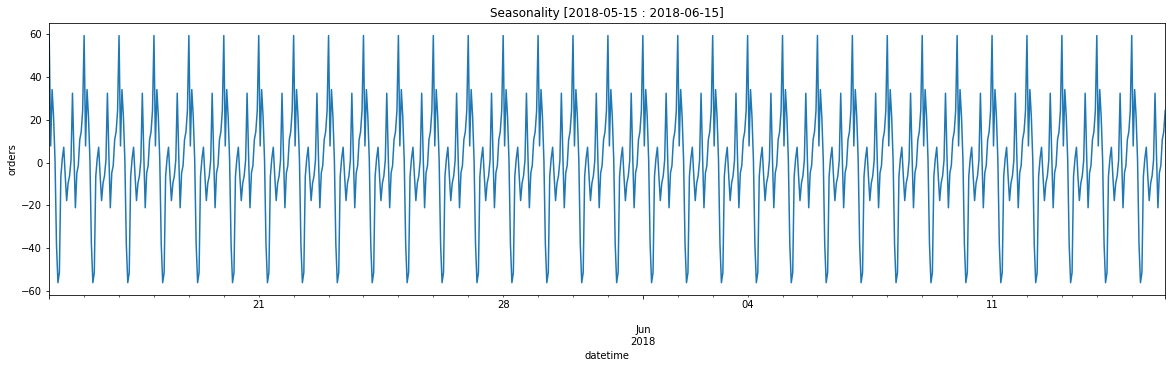

In [11]:
decomposed_vs.seasonal['2018-05-15':'2018-06-15'].plot(figsize=(20,5), 
                                                       xlabel='datetime',  
                                                       ylabel='orders', 
                                                       title='Seasonality [2018-05-15 : 2018-06-15]');

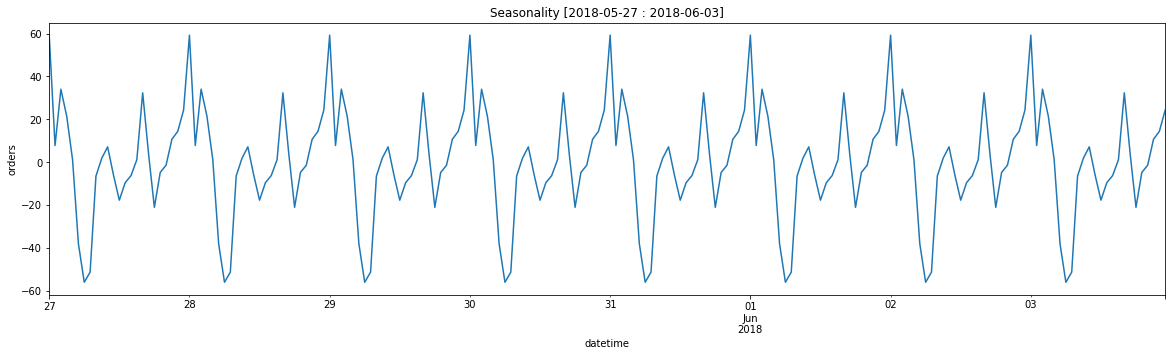

In [12]:
decomposed_vs.seasonal['2018-05-27':'2018-06-03'].plot(figsize=(20,5), 
                                                       xlabel='datetime',                                                        
                                                       ylabel='orders', 
                                                       title='Seasonality [2018-05-27 : 2018-06-03]');

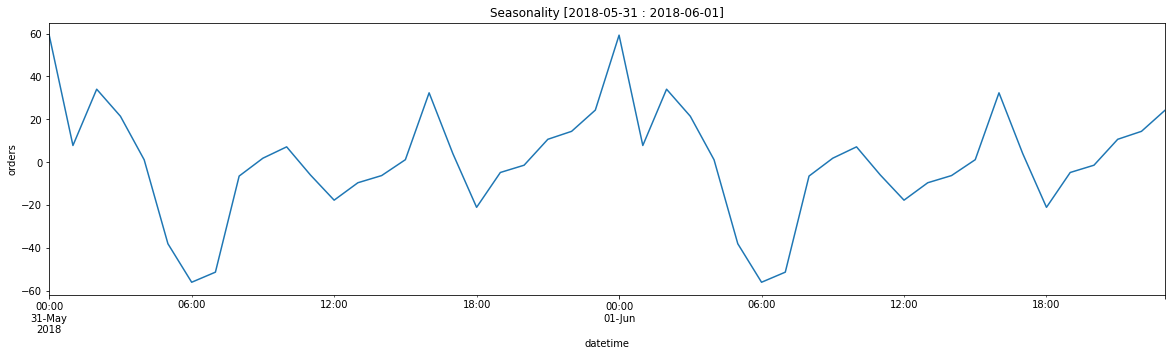

In [13]:
decomposed_vs.seasonal['2018-05-31':'2018-06-01'].plot(figsize=(20,5), 
                                                       xlabel='datetime',                                                        
                                                       ylabel='orders', 
                                                       title='Seasonality [2018-05-31 : 2018-06-01]');

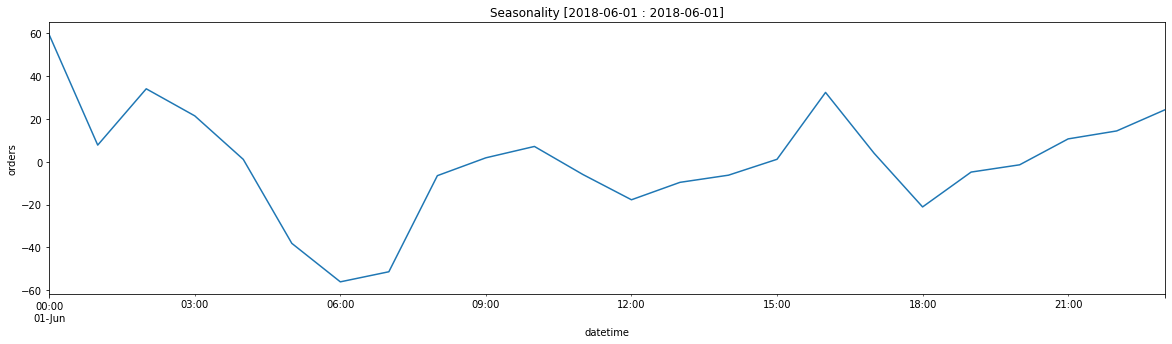

In [14]:
decomposed_vs.seasonal['2018-06-01':'2018-06-01'].plot(figsize=(20,5), 
                                                       xlabel='datetime',                                                        
                                                       ylabel='orders', 
                                                       title='Seasonality [2018-06-01 : 2018-06-01]');

**Рассмотрев графики, можно заметить, что сезонность является суточной
<br>Пики заказов приходится на ночное время до 3х часов, тут есть пара вариантов причин - 
<br> 1) (не знаю с каких аэропортов статистика) Если тут есть статистика на аэропорты в регионах, где не так много перелетов, то там основная масса идет на ночь и утро
<br> 2) Ночью не ходит обещственный транспорт
<br> 3) В дневное время есть подъем, наверно это те, кто приезжает за ранее на рейс, который в 23:00
<br> 4) Популярные рейсы в точках подъема (прим Питер)
<br>Ну и спад приходится с 3 ночи, если я правильно понимаю, там перелеты не проводятся особо. Так же спады от обратного к пиках, к примеру сейчас не популярные рейсы итд
<br>**

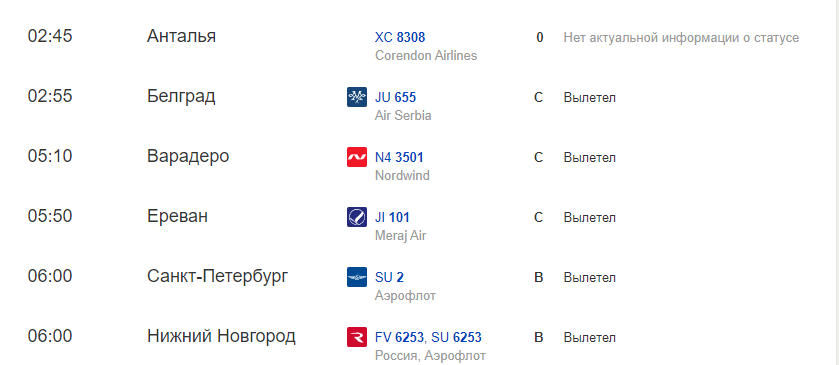

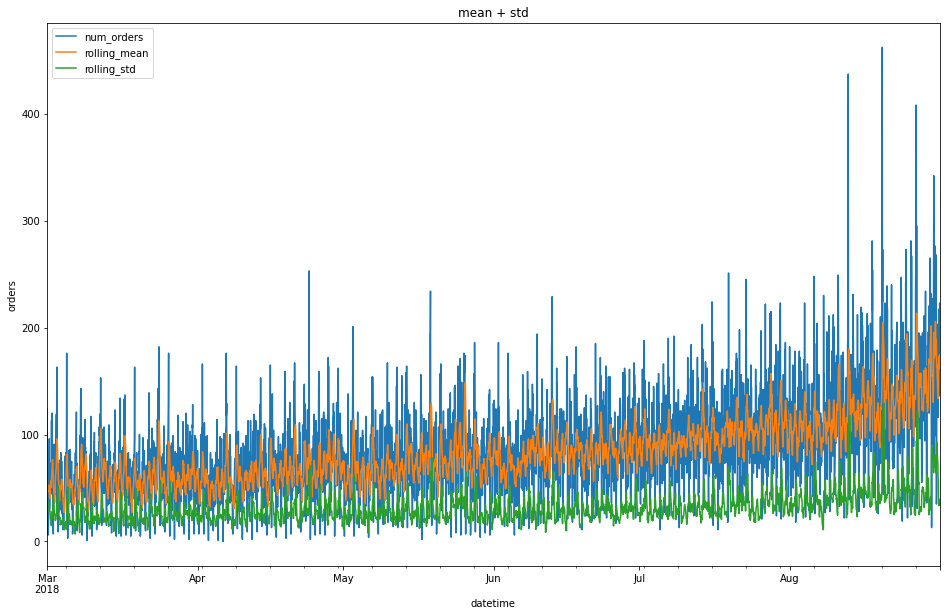

In [15]:
# скользящее среднее тоже указывает на летний рост
df['rolling_mean'] = df.rolling(10).mean()
df['rolling_std'] = df['num_orders'].rolling(10).std()
df.plot(figsize=(16,10), 
        xlabel='datetime',                                                        
        ylabel='orders', 
        title='mean + std');

In [16]:
result = adfuller(df['num_orders'], autolag = 'AIC')
print('Критерий ADF: %f' % result[0])
print('P-значение: %f' % result[1])
print('Критические значения:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] > result[4]["1%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд не стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд не стационарен


**В связи роста тренда, среднее и отклонение изменяются во времени. Также тест Дики-Фуллера на 99% достоверен, что временной ряд не стационарен**

**На этапе анализа видно заметный рост с наступления лета в плане перевозки пассажиров. В начале весны не так заметно, но чем ближе к лету, тем больше поездок становится. Все хотят в отпуск
<br>Была замечена суточная сезонность, где резкое падение в середине ночи и подъем с динамикой обратно
<br>Так же было выявлено, что временной ряд является нестационарным**

## Обучение

In [17]:
# выделим признаки для обучения
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour
df['day'] = df.index.day
df = df.drop('rolling_std', axis=1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   uint16 
 1   rolling_mean  4407 non-null   float64
 2   dayofweek     4416 non-null   int64  
 3   hour          4416 non-null   int64  
 4   day           4416 non-null   int64  
dtypes: float64(1), int64(3), uint16(1)
memory usage: 310.2 KB


In [19]:
# очистим пропуски
df = df.dropna()

In [20]:
# понизим разряд
df = df.astype({
    'rolling_mean' : 'float32',
    'dayofweek' : 'uint8',
    'hour' : 'uint8',
    'day' : 'uint8',
})

In [21]:
# Создадим выборки
X = df.drop('num_orders', axis = 1)
y = df['num_orders']

In [22]:
# разобьем данные
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12345, shuffle=False)

In [23]:
param_grid = {
      'n_estimators': range(100,1000,100),
      'max_depth': range(1,11)}
tsscv = TimeSeriesSplit()

**LGBMRegressor**

In [24]:
%%time
estimator = LGBMRegressor(random_state=12345)
model_lgbm = RandomizedSearchCV(estimator, 
                          param_grid,
                          verbose = False,
                          n_jobs=-1, 
                          cv=tsscv,
                          scoring='neg_mean_squared_error')
model_lgbm.fit(X_train, y_train)

display(abs(model_lgbm.best_score_)**0.5)

parametrs_lgbm = model_lgbm.best_params_
display(parametrs_lgbm)

best_model_lgbm = model_lgbm.best_estimator_

23.73102572679229

{'n_estimators': 100, 'max_depth': 4}

CPU times: user 1min 39s, sys: 964 ms, total: 1min 40s
Wall time: 1min 40s


**catboost**

In [26]:
%%time
estimator = CatBoostRegressor(random_state=12345, verbose = False)
model_cbr = RandomizedSearchCV(estimator, 
                          param_grid,
                          verbose = False,
                          n_jobs=-1, 
                          cv=tsscv,
                          scoring='neg_mean_squared_error')
model_cbr.fit(X_train, y_train)

display(abs(model_cbr.best_score_)**0.5)

parametrs_cbr = model_cbr.best_params_
display(parametrs_cbr)

best_model_cbr = model_cbr.best_estimator_

23.676245892253377

{'n_estimators': 700, 'max_depth': 3}

CPU times: user 33.7 s, sys: 2.2 s, total: 35.9 s
Wall time: 1min 2s


**XGBRegressor**

In [28]:
%%time
estimator = XGBRegressor(random_state=12345)
model_xgbr = RandomizedSearchCV(estimator, 
                          param_grid,
                          verbose = False,
                          n_jobs=-1, 
                          cv=tsscv,
                          scoring='neg_mean_squared_error'
                     )
model_xgbr.fit(X_train, y_train)

display(abs(model_xgbr.best_score_)**0.5)

parametrs_xgbr = model_xgbr.best_params_
display(parametrs_xgbr)

best_model_xgbr = model_xgbr.best_estimator_

24.52637254955272

{'n_estimators': 500, 'max_depth': 1}

CPU times: user 10min 14s, sys: 3.35 s, total: 10min 17s
Wall time: 10min 22s


In [30]:
%%time
estimator = RandomForestRegressor(random_state=12345)
model_rfr = RandomizedSearchCV(estimator, 
                          param_grid,
                          verbose = False,
                          n_jobs=-1, 
                          cv=tsscv,
                          scoring='neg_mean_squared_error'
                     )
model_rfr.fit(X_train, y_train)

display(abs(model_rfr.best_score_)**0.5)

parametrs_rfr = model_rfr.best_params_
display(parametrs_rfr)

best_model_rfr = model_rfr.best_estimator_

24.670161285569055

{'n_estimators': 900, 'max_depth': 8}

CPU times: user 1min 1s, sys: 478 ms, total: 1min 1s
Wall time: 1min 1s


**Проверив четыре модели, в целом показывают +/- одинаковые результаты
<br>XGBRegressor слишком медленно считался, по сравнению с остальными
<br>По точности выйгрывает catboost, да и скорость обучения одна из лучший**

## Тестирование

In [31]:
model_dr = DummyRegressor(strategy="mean")
model_dr.fit(X_train, y_train) 

preds_model_dr = model_dr.predict(X_test)
mean_squared_error(y_test, preds_model_dr) ** 0.5

84.78301353487937

In [32]:
preds_model_cbr = best_model_cbr.predict(X_test)
mse_model_cbr = mean_squared_error(y_test, preds_model_cbr)
print("RMSE для  LightGBM на тестовой выборке:", (mse_model_cbr) ** 0.5)

RMSE для  LightGBM на тестовой выборке: 38.17871251068625


**Как и требовал заказчик RMSE < 48
<br>По сравнению с константной моделью результаты явно лучше**

## Вывод

**Данные в целом были упорядочены и готовы к обучению.
<br>Анализ показал увеличение спроса на такси в летний период. Но для годовалых прогнозов данных не достаточно.
<br>Замечена суточная сезонность
<br>Выявлено, что временной ряд является нестационарным
<br>Выбрана лучшая модель, с точностью удовлетворябщая ТЗ**
